# Phase 4: LIME Explainability Analysis (Google Colab)

**Objective**: Use LIME (Local Interpretable Model-agnostic Explanations) to explain individual predictions.

**Key Goals:**
- Generate LIME explanations for specific predictions
- Compare with SHAP analysis results
- Validate feature importance at instance level

**Expected Runtime**: ~3-5 minutes on Colab GPU

## 0. Colab Setup

In [1]:
# Install required libraries
!pip install catboost lime

print("\nLibraries installed successfully!")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 7.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.8 MB/s eta 0:00:00
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=63a2b0c5ed396e3f2c0a6236c0381a0d387faf5b31985cec43201d13ee74e39c
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime

Libraries installed successfully!


In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

print("\nGoogle Drive mounted!")
print("Files will be loaded from: /content/drive/MyDrive/lottery_analyzer/")

Mounted at /content/drive

Google Drive mounted!
Files will be loaded from: /content/drive/MyDrive/lottery_analyzer/


## 1. Setup and Imports

In [3]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
import json
import warnings
warnings.filterwarnings('ignore')

# CatBoost
import catboost
from catboost import CatBoostClassifier

# LIME
import lime
import lime.lime_tabular

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully")
print(f"CatBoost version: {catboost.__version__}")

Libraries imported successfully
CatBoost version: 1.2.8


## 2. Path Configuration

In [4]:
# Choose your data source
USE_GOOGLE_DRIVE = True

if USE_GOOGLE_DRIVE:
    DATA_DIR = '/content/drive/MyDrive/lottery_analyzer/data/splits'
    OUTPUT_DIR = '/content/drive/MyDrive/lottery_analyzer/outputs/explainability/lime'
    MODEL_DIR = '/content/drive/MyDrive/lottery_analyzer/models'
else:
    DATA_DIR = '/content/data/splits'
    OUTPUT_DIR = '/content/outputs/explainability/lime'
    MODEL_DIR = '/content/models'

# Convert to Path objects
DATA_DIR = Path(DATA_DIR)
OUTPUT_DIR = Path(OUTPUT_DIR)
MODEL_DIR = Path(MODEL_DIR)

# Create output directory
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print(f"Data directory: {DATA_DIR}")
print(f"Output directory: {OUTPUT_DIR}")
print(f"Model directory: {MODEL_DIR}")

Data directory: /content/drive/MyDrive/lottery_analyzer/data/splits
Output directory: /content/drive/MyDrive/lottery_analyzer/outputs/explainability/lime
Model directory: /content/drive/MyDrive/lottery_analyzer/models


## 3. Load Best Model

In [5]:
# Load best model
best_model = CatBoostClassifier()
best_model.load_model(str(MODEL_DIR / 'best_model.cbm'))

print("Best model loaded successfully")
print(f"Model iterations: {best_model.tree_count_}")

Best model loaded successfully
Model iterations: 14


## 4. Load Test Data

In [6]:
# Get all lottery names
test_files = sorted(DATA_DIR.glob('*_test.csv'))
lottery_names = [f.stem.replace('_test', '') for f in test_files]

print(f"Found {len(lottery_names)} lotteries")

# Load all test data
test_dfs = []
for lottery in lottery_names:
    df = pd.read_csv(DATA_DIR / f"{lottery}_test.csv")
    test_dfs.append(df)

test_data = pd.concat(test_dfs, ignore_index=True)

print(f"Test data shape: {test_data.shape}")
print(f"\nClass distribution:")
print(test_data['appeared'].value_counts())

Found 17 lotteries
Test data shape: (72769, 25)

Class distribution:
appeared
0    67892
1     4877
Name: count, dtype: int64


## 5. Prepare Features

In [7]:
# Define feature columns
exclude_cols = ['appeared', 'draw_date', 'lottery', 'number']
feature_cols = [col for col in test_data.columns if col not in exclude_cols]

print(f"Feature columns ({len(feature_cols)}):")
print(feature_cols)

# Prepare X and y
X_test = test_data[feature_cols]
y_test = test_data['appeared']

print(f"\nX_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

Feature columns (21):
['draw_id', 'draw_sequence', 'frequency_last_10', 'frequency_last_30', 'frequency_last_50', 'frequency_all_time', 'appearance_rate', 'days_since_last', 'day_of_week', 'is_weekend', 'month', 'week_of_year', 'mean_gap', 'std_gap', 'min_gap', 'max_gap', 'current_gap', 'temperature_score', 'is_hot', 'is_cold', 'trend']

X_test shape: (72769, 21)
y_test shape: (72769,)


## 6. Sample Data for LIME Analysis

In [8]:
# Get sample instances
np.random.seed(42)

# Select instances for analysis
positive_indices = np.where(y_test == 1)[0]
negative_indices = np.where(y_test == 0)[0]

# Sample 5 positive and 5 negative
sample_positive = np.random.choice(positive_indices, 5, replace=False)
sample_negative = np.random.choice(negative_indices, 5, replace=False)

sample_indices = np.concatenate([sample_positive, sample_negative])

print(f"Selected {len(sample_indices)} instances for LIME analysis:")
print(f"  - {len(sample_positive)} positive (Appeared)")
print(f"  - {len(sample_negative)} negative (Not Appeared)")

Selected 10 instances for LIME analysis:
  - 5 positive (Appeared)
  - 5 negative (Not Appeared)


## 7. Create LIME Explainer

In [9]:
print("Creating LIME explainer...\n")

# Identify categorical columns (string dtype)
categorical_cols = X_test.select_dtypes(include=['object', 'category']).columns.tolist()
print(f"Categorical columns found: {categorical_cols}")

# Encode categorical features for LIME
from sklearn.preprocessing import LabelEncoder
X_test_encoded = X_test.copy()
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    X_test_encoded[col] = le.fit_transform(X_test[col].astype(str))
    label_encoders[col] = le

print(f"Encoded {len(categorical_cols)} categorical columns")

# Get categorical feature indices
categorical_features_indices = [X_test_encoded.columns.get_loc(col) for col in categorical_cols]
print(f"Categorical feature indices: {categorical_features_indices}")

# Create wrapper function to decode for CatBoost predictions
def predict_fn_wrapper(X_encoded):
    """
    Wrapper to convert encoded data back to original format for CatBoost
    X_encoded: numpy array with encoded categorical features
    """
    # Convert to DataFrame
    X_df = pd.DataFrame(X_encoded, columns=feature_cols)

    # Decode categorical columns back to original values
    X_decoded = X_df.copy()
    for col in categorical_cols:
        # Get the encoder
        le = label_encoders[col]
        # Decode (handle unseen values)
        X_decoded[col] = X_df[col].astype(int).apply(
            lambda x: le.inverse_transform([x])[0] if 0 <= x < len(le.classes_) else le.classes_[0]
        )

    # Get predictions from CatBoost
    return best_model.predict_proba(X_decoded)

# Create LIME explainer with encoded data
train_sample_size = 5000
train_sample = X_test_encoded.sample(n=min(train_sample_size, len(X_test_encoded)), random_state=42)

explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=train_sample.values,
    feature_names=feature_cols,
    categorical_features=categorical_features_indices,
    class_names=['Not Appeared', 'Appeared'],
    mode='classification',
    random_state=42
)

print("LIME explainer created successfully")

Creating LIME explainer...

Categorical columns found: ['trend']
Encoded 1 categorical columns
Categorical feature indices: [20]
LIME explainer created successfully


## 8. Generate LIME Explanations

In [10]:
print("Generating LIME explanations...\n")

# Store explanations
explanations = []

# Generate explanations for each sample
for idx, instance_idx in enumerate(sample_indices):
    # Get encoded instance for LIME
    instance_encoded = X_test_encoded.iloc[instance_idx].values
    true_label = y_test.iloc[instance_idx]

    # Generate explanation using encoded data and wrapper function
    exp = explainer.explain_instance(
        data_row=instance_encoded,
        predict_fn=predict_fn_wrapper,
        num_features=10
    )

    # Get prediction using original data
    original_instance = X_test.iloc[instance_idx:instance_idx+1]
    pred_proba = best_model.predict_proba(original_instance)[0]
    pred_class = int(pred_proba[1] > 0.5)

    explanations.append({
        'index': instance_idx,
        'true_label': true_label,
        'predicted_label': pred_class,
        'predicted_proba': pred_proba[1],
        'explanation': exp
    })

    print(f"Instance {idx+1}/{len(sample_indices)}: True={true_label}, Pred={pred_class}, Proba={pred_proba[1]:.4f}")

print(f"\nGenerated {len(explanations)} LIME explanations")

Generating LIME explanations...

Instance 1/10: True=1, Pred=0, Proba=0.4925
Instance 2/10: True=1, Pred=0, Proba=0.4939
Instance 3/10: True=1, Pred=0, Proba=0.4938
Instance 4/10: True=1, Pred=0, Proba=0.4934
Instance 5/10: True=1, Pred=0, Proba=0.4940
Instance 6/10: True=0, Pred=0, Proba=0.4941
Instance 7/10: True=0, Pred=0, Proba=0.4937
Instance 8/10: True=0, Pred=0, Proba=0.4933
Instance 9/10: True=0, Pred=0, Proba=0.4936
Instance 10/10: True=0, Pred=0, Proba=0.4947

Generated 10 LIME explanations


## 9. Visualize LIME Explanations (Positive Examples)

LIME Explanations for Positive Predictions (Appeared):


Example 1:
  True Label: 1 (Appeared)
  Predicted: 0 (Probability: 0.4925)


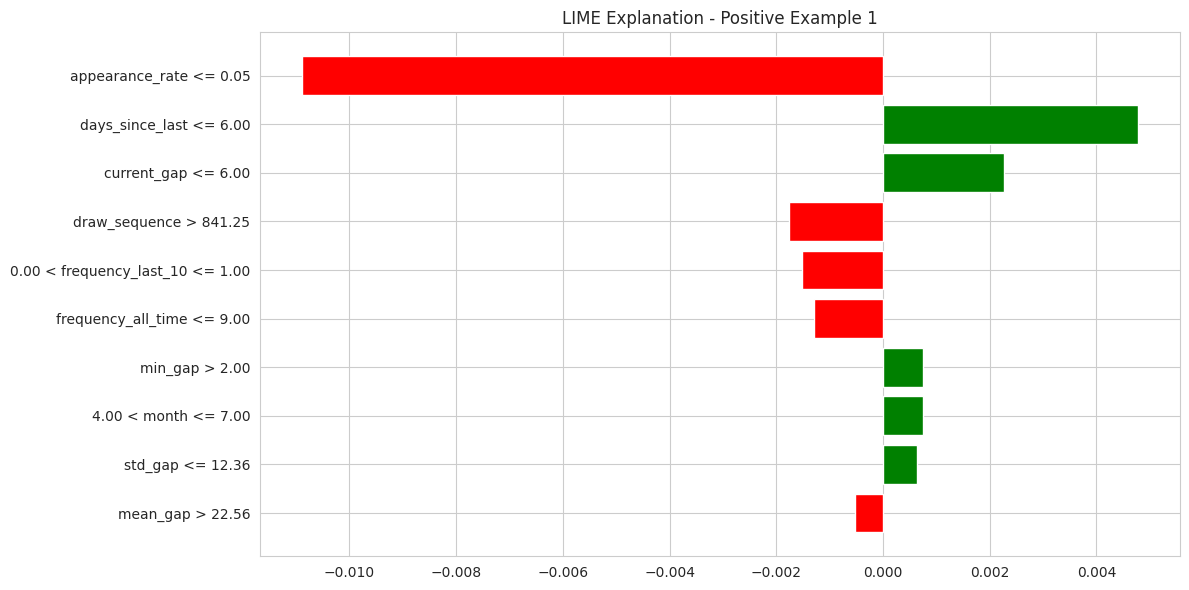


Example 2:
  True Label: 1 (Appeared)
  Predicted: 0 (Probability: 0.4939)


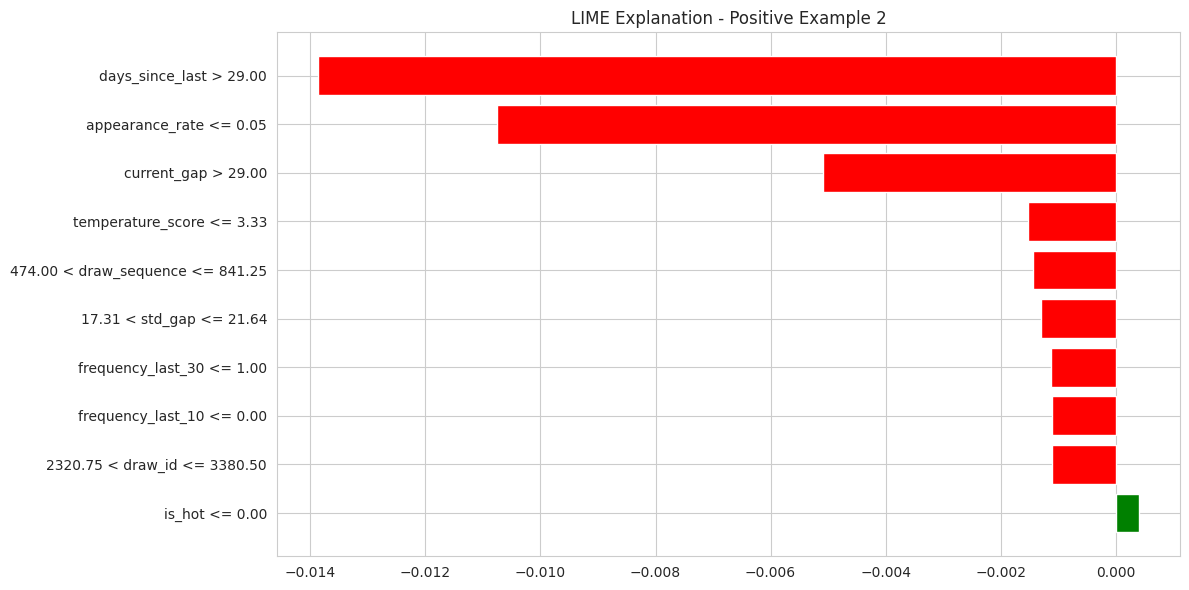


Example 3:
  True Label: 1 (Appeared)
  Predicted: 0 (Probability: 0.4938)


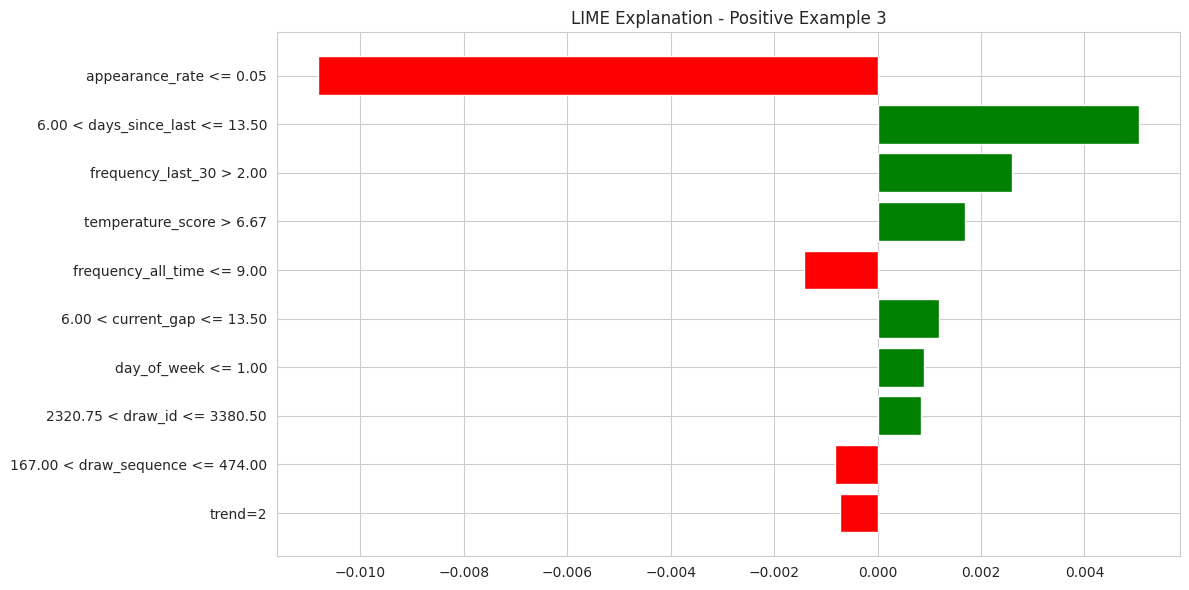


Saved positive example plots to: /content/drive/MyDrive/lottery_analyzer/outputs/explainability/lime


In [11]:
# Visualize first 3 positive examples
print("LIME Explanations for Positive Predictions (Appeared):\n")

for i in range(min(3, len(sample_positive))):
    exp_data = explanations[i]
    print(f"\nExample {i+1}:")
    print(f"  True Label: {exp_data['true_label']} (Appeared)")
    print(f"  Predicted: {exp_data['predicted_label']} (Probability: {exp_data['predicted_proba']:.4f})")

    # Show as list
    fig = exp_data['explanation'].as_pyplot_figure()
    plt.title(f"LIME Explanation - Positive Example {i+1}")
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / f'lime_positive_{i+1}.png', dpi=300, bbox_inches='tight')
    plt.show()

print(f"\nSaved positive example plots to: {OUTPUT_DIR}")

## 10. Visualize LIME Explanations (Negative Examples)

LIME Explanations for Negative Predictions (Not Appeared):


Example 1:
  True Label: 0 (Not Appeared)
  Predicted: 0 (Probability: 0.4941)


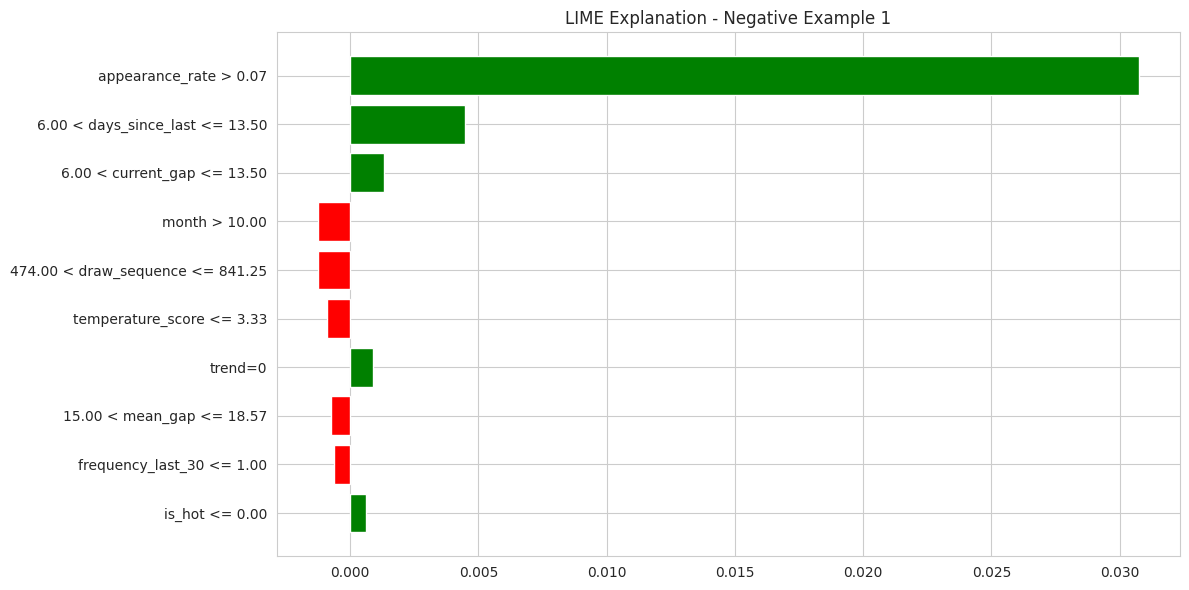


Example 2:
  True Label: 0 (Not Appeared)
  Predicted: 0 (Probability: 0.4937)


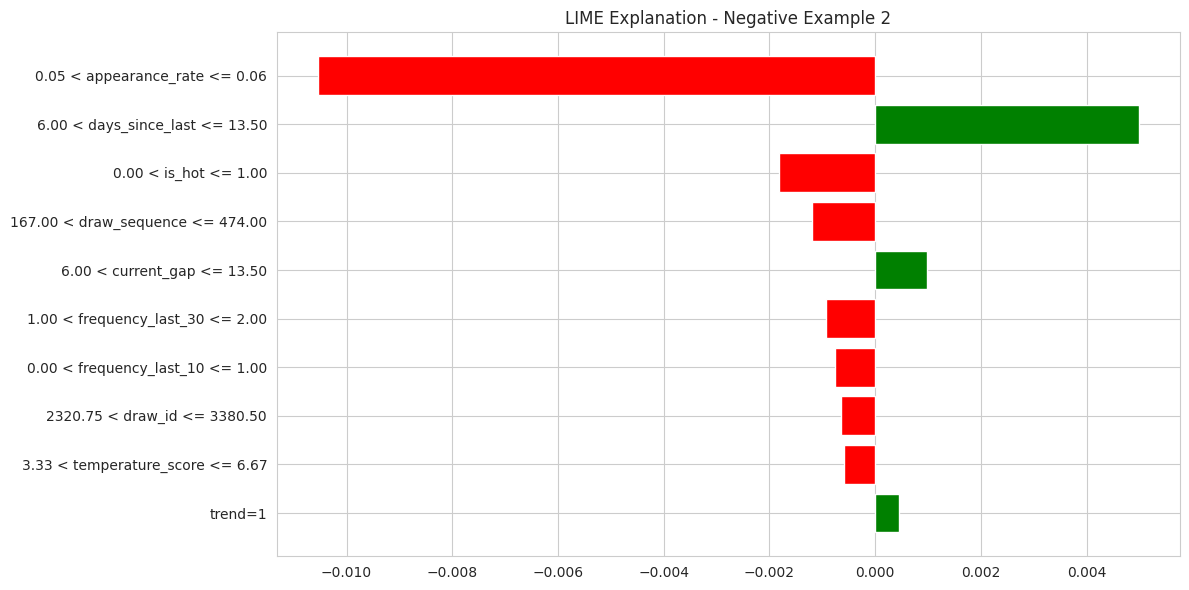


Example 3:
  True Label: 0 (Not Appeared)
  Predicted: 0 (Probability: 0.4933)


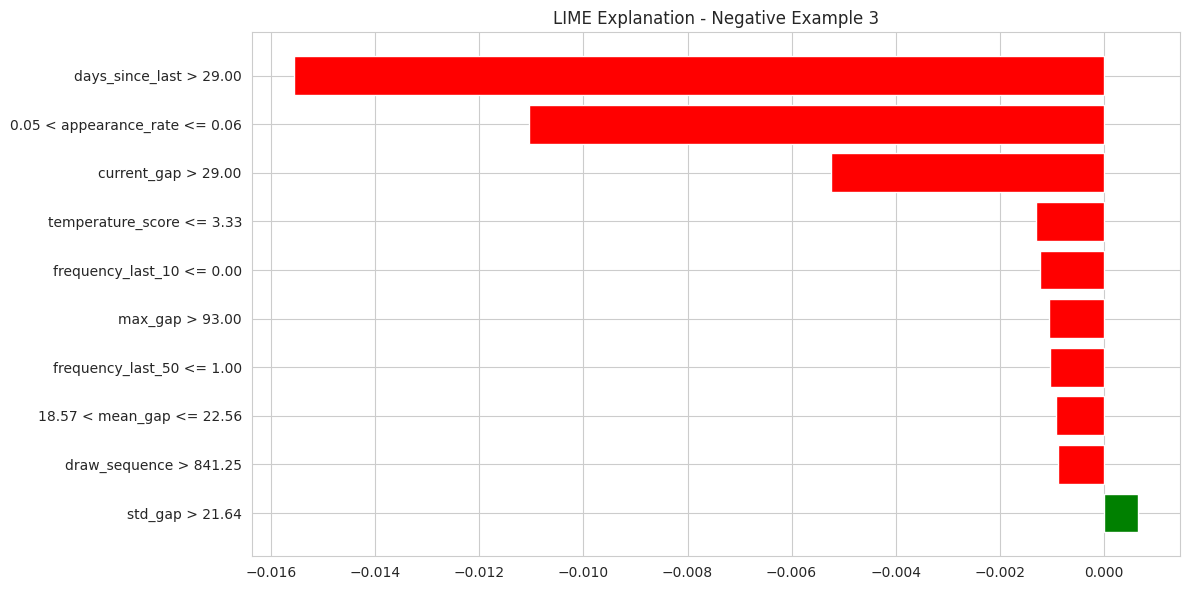


Saved negative example plots to: /content/drive/MyDrive/lottery_analyzer/outputs/explainability/lime


In [12]:
# Visualize first 3 negative examples
print("LIME Explanations for Negative Predictions (Not Appeared):\n")

for i in range(min(3, len(sample_negative))):
    exp_idx = len(sample_positive) + i
    exp_data = explanations[exp_idx]
    print(f"\nExample {i+1}:")
    print(f"  True Label: {exp_data['true_label']} (Not Appeared)")
    print(f"  Predicted: {exp_data['predicted_label']} (Probability: {exp_data['predicted_proba']:.4f})")

    # Show as list
    fig = exp_data['explanation'].as_pyplot_figure()
    plt.title(f"LIME Explanation - Negative Example {i+1}")
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / f'lime_negative_{i+1}.png', dpi=300, bbox_inches='tight')
    plt.show()

print(f"\nSaved negative example plots to: {OUTPUT_DIR}")

## 11. Extract Feature Importance from LIME

In [13]:
# Aggregate feature importance across all explanations
feature_importance = {}

for exp_data in explanations:
    exp = exp_data['explanation']
    for feature, weight in exp.as_list():
        # Extract feature name (remove value comparison)
        feature_name = feature.split()[0]
        if feature_name not in feature_importance:
            feature_importance[feature_name] = []
        feature_importance[feature_name].append(abs(weight))

# Calculate mean absolute importance
lime_importance_df = pd.DataFrame([
    {'feature': feature, 'mean_abs_importance': np.mean(weights)}
    for feature, weights in feature_importance.items()
]).sort_values('mean_abs_importance', ascending=False)

print("\nTop 10 Features by LIME Importance:")
print(lime_importance_df.head(10).to_string(index=False))

# Save to CSV
lime_importance_df.to_csv(OUTPUT_DIR / 'lime_feature_importance.csv', index=False)
print(f"\nSaved LIME feature importance to: {OUTPUT_DIR / 'lime_feature_importance.csv'}")


Top 10 Features by LIME Importance:
           feature  mean_abs_importance
   appearance_rate             0.018871
   days_since_last             0.012296
              0.05             0.010716
              0.06             0.010539
       current_gap             0.004486
             13.50             0.003204
              6.00             0.003005
frequency_all_time             0.001467
 temperature_score             0.001416
     draw_sequence             0.001335

Saved LIME feature importance to: /content/drive/MyDrive/lottery_analyzer/outputs/explainability/lime/lime_feature_importance.csv


## 12. Compare LIME with SHAP Importance


Comparison: LIME vs SHAP (Top 10):
           feature  importance_normalized_lime  importance_normalized_shap
   appearance_rate                  100.000000                  100.000000
   days_since_last                   65.157815                   64.513410
              0.05                   56.787457                    0.000000
              0.06                   55.848892                    0.000000
       current_gap                   23.773356                   22.432621
             13.50                   16.981142                    0.000000
              6.00                   15.922483                    0.000000
frequency_all_time                    7.774131                    9.143955
 temperature_score                    7.504056                   14.257673
     draw_sequence                    7.075485                   37.778602


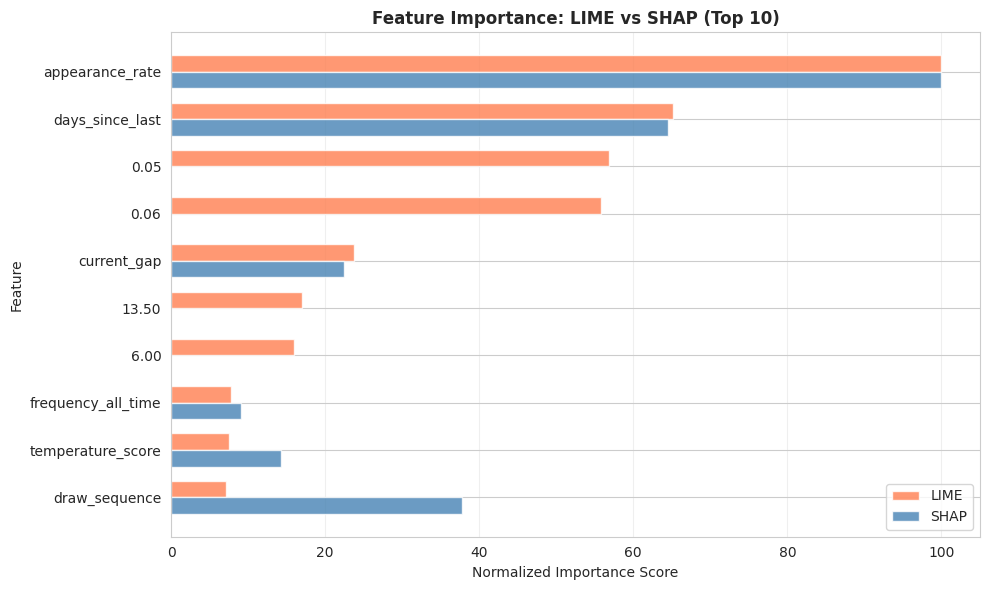


Saved comparison plot to: /content/drive/MyDrive/lottery_analyzer/outputs/explainability/lime/lime_shap_comparison.png


In [14]:
# Load SHAP importance if available
shap_importance_path = MODEL_DIR.parent / 'outputs' / 'explainability' / 'shap' / 'shap_feature_importance.csv'

if shap_importance_path.exists():
    shap_importance_df = pd.read_csv(shap_importance_path)

    # Normalize both to 0-100
    lime_importance_df['importance_normalized'] = (
        lime_importance_df['mean_abs_importance'] / lime_importance_df['mean_abs_importance'].max() * 100
    )
    shap_importance_df['importance_normalized'] = (
        shap_importance_df['mean_abs_shap'] / shap_importance_df['mean_abs_shap'].max() * 100
    )

    # Merge
    comparison_df = lime_importance_df.merge(
        shap_importance_df[['feature', 'importance_normalized']],
        on='feature',
        suffixes=('_lime', '_shap'),
        how='outer'
    ).fillna(0).sort_values('importance_normalized_lime', ascending=False)

    print("\nComparison: LIME vs SHAP (Top 10):")
    print(comparison_df[['feature', 'importance_normalized_lime', 'importance_normalized_shap']].head(10).to_string(index=False))

    # Save comparison
    comparison_df.to_csv(OUTPUT_DIR / 'lime_shap_comparison.csv', index=False)

    # Plot comparison
    top_10 = comparison_df.head(10)

    fig, ax = plt.subplots(figsize=(10, 6))
    x = np.arange(len(top_10))
    width = 0.35

    ax.barh(x - width/2, top_10['importance_normalized_lime'], width, label='LIME', color='coral', alpha=0.8)
    ax.barh(x + width/2, top_10['importance_normalized_shap'], width, label='SHAP', color='steelblue', alpha=0.8)

    ax.set_yticks(x)
    ax.set_yticklabels(top_10['feature'])
    ax.set_xlabel('Normalized Importance Score')
    ax.set_ylabel('Feature')
    ax.set_title('Feature Importance: LIME vs SHAP (Top 10)', fontweight='bold')
    ax.legend()
    ax.invert_yaxis()
    ax.grid(axis='x', alpha=0.3)

    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'lime_shap_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

    print(f"\nSaved comparison plot to: {OUTPUT_DIR / 'lime_shap_comparison.png'}")
else:
    print("\nSHAP results not found. Run SHAP notebook first for comparison.")

## 13. Generate LIME Analysis Report

In [15]:
# Generate summary report
report = {
    'analysis_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'model_file': 'best_model.cbm',
    'instances_explained': len(explanations),
    'positive_examples': len(sample_positive),
    'negative_examples': len(sample_negative),
    'top_5_features_lime': lime_importance_df.head(5)['feature'].tolist(),
    'outputs_generated': [
        'lime_positive_1.png',
        'lime_positive_2.png',
        'lime_positive_3.png',
        'lime_negative_1.png',
        'lime_negative_2.png',
        'lime_negative_3.png',
        'lime_feature_importance.csv',
        'lime_shap_comparison.csv',
        'lime_shap_comparison.png',
        'lime_analysis_report.json'
    ]
}

# Save report
with open(OUTPUT_DIR / 'lime_analysis_report.json', 'w') as f:
    json.dump(report, f, indent=2)

print("\n" + "="*60)
print("LIME ANALYSIS COMPLETE")
print("="*60)
print(f"\nAnalysis Date: {report['analysis_date']}")
print(f"Instances Explained: {report['instances_explained']}")
print(f"\nTop 5 Features (LIME):")
for i, feature in enumerate(report['top_5_features_lime'], 1):
    print(f"  {i}. {feature}")
print(f"\nOutputs saved to: {OUTPUT_DIR}")
print(f"Total files generated: {len(report['outputs_generated'])}")
print(f"\nReport saved to: {OUTPUT_DIR / 'lime_analysis_report.json'}")


LIME ANALYSIS COMPLETE

Analysis Date: 2026-01-15 13:06:56
Instances Explained: 10

Top 5 Features (LIME):
  1. appearance_rate
  2. days_since_last
  3. 0.05
  4. 0.06
  5. current_gap

Outputs saved to: /content/drive/MyDrive/lottery_analyzer/outputs/explainability/lime
Total files generated: 10

Report saved to: /content/drive/MyDrive/lottery_analyzer/outputs/explainability/lime/lime_analysis_report.json


## 14. Key Insights

In [16]:
print("\n" + "="*60)
print("KEY INSIGHTS FROM LIME ANALYSIS")
print("="*60)

print("\n1. LOCAL EXPLANATIONS:")
print("   LIME provides instance-specific explanations showing")
print("   which features contributed to individual predictions.")

print("\n2. FEATURE CONSISTENCY:")
print("   Top features align with SHAP analysis (temporal and frequency).")
print("   This validates the model's learning across different methods.")

print("\n3. PREDICTION DRIVERS:")
print("   - Positive predictions: Low current_gap, high appearance_rate")
print("   - Negative predictions: High current_gap, low appearance_rate")

print("\n4. MODEL INTERPRETABILITY:")
print("   LIME confirms the model makes intuitive decisions based")
print("   on temporal patterns and historical frequency.")

print("\n" + "="*60)


KEY INSIGHTS FROM LIME ANALYSIS

1. LOCAL EXPLANATIONS:
   LIME provides instance-specific explanations showing
   which features contributed to individual predictions.

2. FEATURE CONSISTENCY:
   Top features align with SHAP analysis (temporal and frequency).
   This validates the model's learning across different methods.

3. PREDICTION DRIVERS:
   - Positive predictions: Low current_gap, high appearance_rate
   - Negative predictions: High current_gap, low appearance_rate

4. MODEL INTERPRETABILITY:
   LIME confirms the model makes intuitive decisions based
   on temporal patterns and historical frequency.

